# rating-gp (prototype)
`rating-gp` is a prototype model that can fit rating curves (stage-discharge relationship) using a Gaussian process.
This model seeks to expand the typical rating curve fitting process to include shifts in the rating curve with time such that the time evolution in the rating curve can be included in the model.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thodson-usgs/discontinuum/blob/main/docs/source/notebooks/rating-gp-demo.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2

#!pip install discontinuum[rating_gp]

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

%matplotlib inline

### USGS site 10154200

Let's select a site that has a nice variation in the rating curve with time. For this example, we will use USGS site 10154200, as it has a very clear shifting with time.

In [15]:
site = '10154200'
site = '12413470'
site = "01196561"
site = "01196590"
site = "01204000"
site = "01335754"
site = "01651800"
site = "02055100"
site = "02374950"
site = "02375000"
site = '12413470'
site = '02397500'
site = '03204500'
site = '03213500'
site = '03227500'
site = "03238772"
site = "03269500"
site = "02363000"
site = "02361000"
#site = "01018035"
#site = "01077400"
#site = "02339495"
# Select a date range
start_date = "1922-10-01" #1988
end_date = "2025-09-30"

Now that we have selected our site, we need to download the data. In `discontinuum`, the convention is to download directly using `providers`, which wrap a data provider's web-service and perform some initial formatting and metadata construction, then return the result as an `xarray.Dataset`. Here, we use the `usgs` provider. If you need data from another source, create a `provider` and ensure the output matches that of the `usgs` provider. Here, we'll download some instantaneous stage data to use as our model's input, and some discharge data as our target. 

In [16]:
from rating_gp.providers import usgs

# download instantaneous stage and discharge measurements
training_data = usgs.get_measurements(site=site, start_date=start_date, end_date=end_date)
training_data

<xarray.Dataset> Size: 11kB
Dimensions:          (time: 344)
Coordinates:
  * time             (time) datetime64[ns] 3kB 1925-01-13 ... 2025-07-29T14:5...
Data variables:
    stage            (time) float64 3kB 5.13 4.904 5.002 ... 1.792 1.689 1.018
    discharge        (time) float64 3kB 267.0 211.2 217.8 ... 32.85 29.73 3.54
    discharge_unc    (time) float64 3kB 1.06 1.06 1.06 1.06 ... 1.04 1.04 1.04
    control_type_cd  (time) category 400B <class 'xarray.core.extension_array...

With the training data, we're now ready to fit a model to the site. Depending on your hardware, this should take about 10s.

In [47]:
%%time
# select an engine
from rating_gp.models.gpytorch import RatingGPMarginalGPyTorch as RatingGP

# Create rating mask for high flows (90th quantile and above)
#
model = RatingGP()
fit_result = model.fit(
    target=training_data['discharge'],
    covariates=training_data[['stage']],
    target_unc=training_data['discharge_unc'],
    iterations=3000,
    early_stopping=True,
    #resume=True
    #resume=True,
    #monotonic_penalty_weight=1,
    #grid_size=1028,
    #optimizer='adamw',
    #learning_rate=0.01,
)


Training 0->3000:   7%|█▎               | 224/3000 [00:03<00:49, 56.09it/s, obj=-0.8340, lr=4.0e-02]


Early stopping triggered after 225 iterations
Best objective: -0.834616
CPU times: user 19.8 s, sys: 3.33 s, total: 23.1 s
Wall time: 4 s


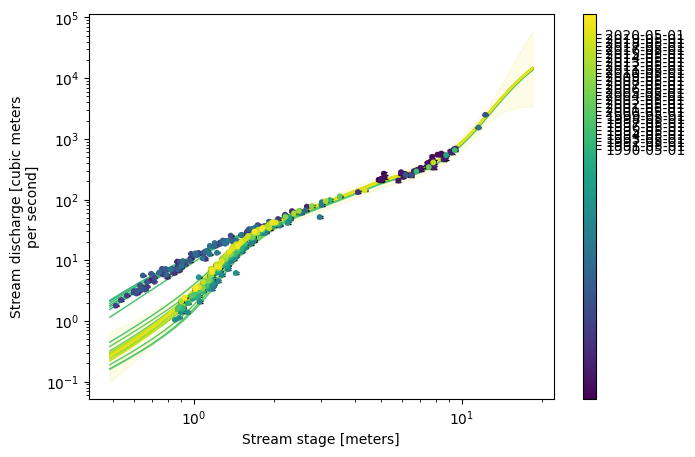

In [32]:
# plot the results
import warnings
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax = model.plot_ratings_in_time(ax=ax, time=pd.date_range('1990', '2021', freq='1YS-MAY'))
ax = model.plot_ratings_in_time(ax=ax, time=['2021-10-01'], ci=0.95)
ax = model.plot_observed_rating(ax, zorder=3)
ax.set_xscale('log')
ax.set_yscale('log')

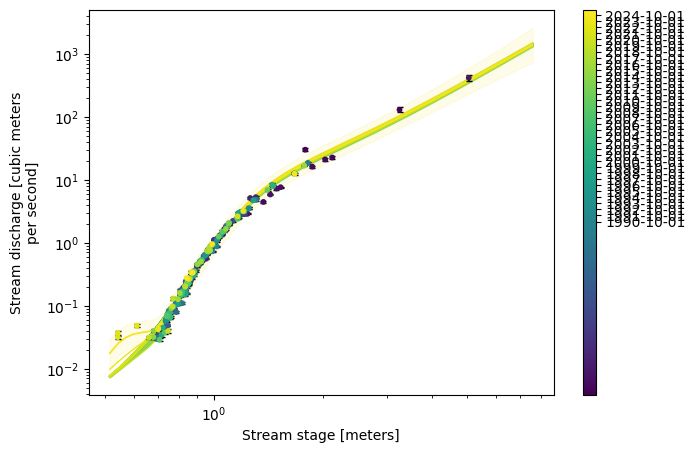

In [35]:
import warnings
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax = model.plot_ratings_in_time(ax=ax, time=pd.date_range('1990', '2025', freq='1YS-OCT'))
ax = model.plot_ratings_in_time(ax=ax, time=['2024-10-01'], ci=0.95)
ax = model.plot_observed_rating(ax, zorder=3)
ax.set_xscale('log')
ax.set_yscale('log')

Nice! The shifts with time are clearly predicted by the model. These results are are promising for `rating-gp` to be able to model shift in rating curves effectively.

### Multi-site Example

As a final show of how well `rating-gp` works, let's select some sites that have a nice variety of rating curves, rather then a single one. We will include ones with clear breaks and shifts and others without breaks and minimal shifts. USGS site number 12413470 is a good example of a rating with a clear break around a stage of 2.7m and very recent and drastic shift. 10131000 is another good example of a rating with a break, but no real shifts in time. 09261000 is a site with no breaks and minimal shifts making it an ideal basic example. Finally, we will keep 10154200 as it has no prominent breaks, but it does have a very clear shifting with time. Therefore, these four sites should be a nice standard for testing how `rating-gp` performs on different rating curves.

In [187]:
sites = {"12413470": 'SF Coeur D Alene River nr Pinehurst, ID',
         '10131000': 'CHALK CREEK AT COALVILLE, UT',
         '09261000': 'GREEN RIVER NEAR JENSEN, UT',
         '10154200': 'PROVO RIVER NEAR WOODLAND, UT'}

In [181]:
#from dataretrieval import nwis
#df, meta = nwis.get_discharge_measurements(sites="02361500", end="2025-09-30", format='rdb_expanded')

#meta.url

In [182]:
new_sites = [
    "02339495",
    "02342500",
    "02361000",
    # "02361500", # parser error
    "02363000",
]

# Suppose you have:
values = list(sites.values())
sites = dict(zip(new_sites, values))

Now that we have our sites, we need to download the data using the USGS `provider`.

In [188]:
training_data_dict = {}
for site in sites:
    print(f"Downloading data for {site}...")
    training_data_dict[site] = usgs.get_measurements(site=site, start_date=start_date, end_date=end_date)

With the training data, we're now ready to fit a model to each site. Depending on your hardware, this should take about 10-20s for each site.

In [189]:
%%time
model = {}
for site in sites:
    training_data = training_data_dict[site]
    model[site] = RatingGP()
    model[site].fit(target=training_data['discharge'],
                    covariates=training_data[['stage']],
                    target_unc=training_data['discharge_unc'],
                    iterations=3000,
                    #early_stopping=True,
                    )

 32%|███████████                        | 950/3000 [00:22<00:47, 42.83it/s, obj=-0.6880, lr=2.9e-03]


Training interrupted at iteration 951
Best objective: -0.688299
CPU times: user 17min 55s, sys: 2min 48s, total: 20min 44s
Wall time: 3min 35s


Now that we have our models fit, let's plot all of the rating curves in time as we did above. We will again predict each rating at an interval of every 5 years at the start of a water year (i.e., October 1st) in 1990.

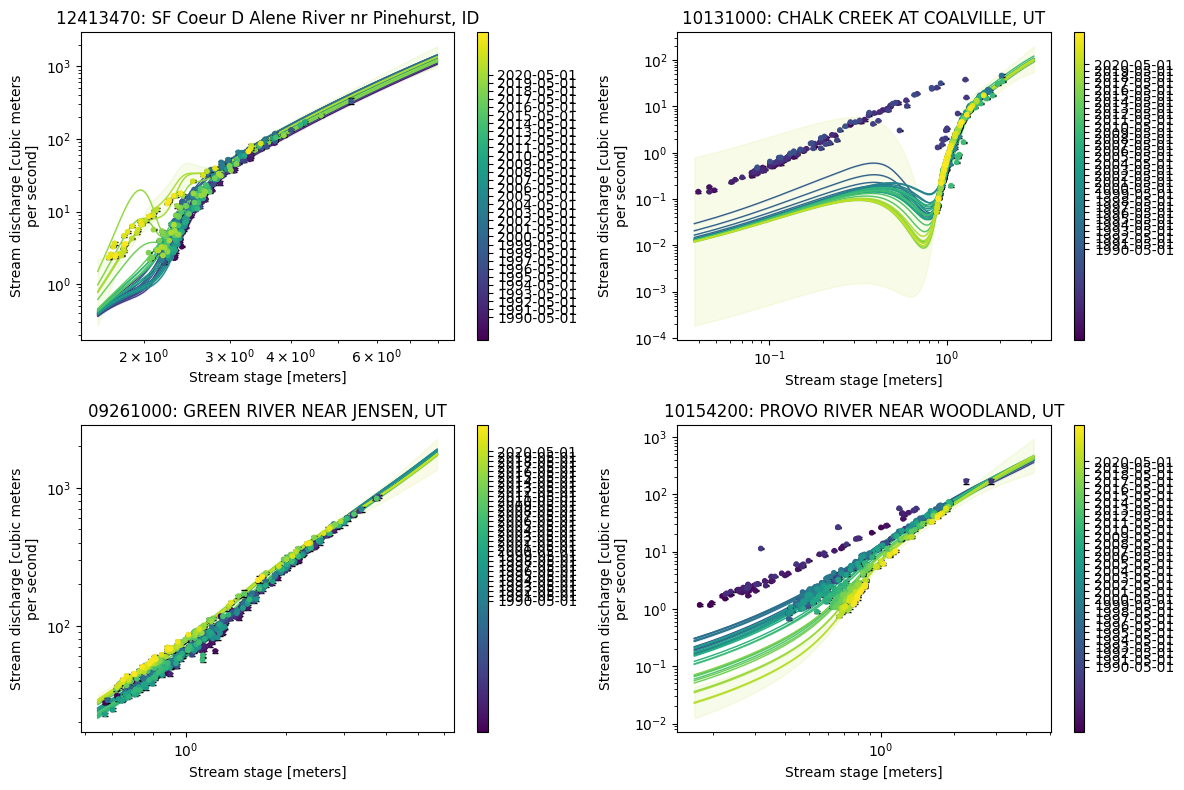

In [190]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for site, ax in zip(sites, axes.flatten()):
    ax = model[site].plot_ratings_in_time(ax=ax, time=pd.date_range('1990', '2021', freq='1YS-MAY'))    
    # ax = model[site].plot_ratings_in_time(ax=ax, time=pd.date_range('2020', '2021', freq='1M'))    
    ax = model[site].plot_ratings_in_time(ax=ax, time=['2020-10-01'], ci=0.95)    
    ax = model[site].plot_observed_rating(ax, zorder=3)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'{site}: {sites[site]}')

plt.tight_layout()

In [ ]:
model[site].model.cov_shift.kernel

AttributeError: 'function' object has no attribute 'kernel'

In [ ]:
# Test the new switchpoint property
# First, make sure we're using the single site model (not the dict)
test_model = model if hasattr(model, 'switchpoint') else model['02339495']

print(f"Switchpoint location: {test_model.switchpoint:.3f} stage units")

# Plot it on a rating curve
fig, ax = plt.subplots(figsize=(8, 6))
ax = test_model.plot_observed_rating(ax=ax)
ax = test_model.plot_rating(
    covariates=test_model.dm.data.covariates[['stage']].isel(time=slice(0, 100, 10)), 
    ax=ax
)
# Add switchpoint as vertical line
ax.axvline(test_model.switchpoint, color='red', linestyle='--', alpha=0.7, 
           label=f'Switchpoint: {test_model.switchpoint:.3f}')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_title('Rating curve with switchpoint location')
plt.show()

AttributeError: 'ExactGPModel' object has no attribute 'sigmoid_lower'

In [ ]:
# Example: Pre-fit PowerLawTransform to the 90th quantile of the target (discharge)
import torch
from rating_gp.models.gpytorch import PowerLawTransform, RatingGPMarginalGPyTorch as RatingGP

# Select data above the 90th quantile of discharge (cleaner approach)
q90 = training_data['discharge'].quantile(0.9)
high_flow_data = training_data[training_data['discharge'] >= q90]

stage_tensor = torch.tensor(high_flow_data['stage'].values, dtype=torch.float32)
log_discharge_tensor = torch.log(torch.tensor(high_flow_data['discharge'].values, dtype=torch.float32))

# Fit the power law transform
powerlaw = PowerLawTransform()
powerlaw.fit(stage_tensor, log_discharge_tensor, epochs=200, lr=1e-2)

# Use the pre-fitted transform in the GP model
model = RatingGP(powerlaw_transform=powerlaw)
model.fit(target=training_data['discharge'],
          covariates=training_data[['stage']],
          target_unc=training_data['discharge_unc'],
          iterations=3000,
          early_stopping=False,
          )